In [1]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

Mounted at /content/drive


In [0]:
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

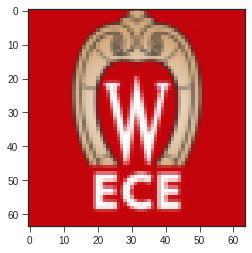

In [3]:
import numpy as np;
import matplotlib.pyplot as plt;
plt.style.use(['seaborn-ticks']);
#import matplotlib.image as mpimg;

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;



r = 64;
c = 64;

#########################################################
ratio_val = 0.; ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################
#cycles = [1000]
error = [];

pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = True, size = (r,c), anti_aliasing = False);  

In [0]:
n_ph_per_sec = 1e6;

maximum_time = 150;
data_density = 15;
time = (np.arange(data_density)+1)/data_density*maximum_time;
time = [1e-2, 1e-1,1e-0] + list(time);

Error_raster_local = np.zeros(len(time));
Error_raster_global = np.zeros(len(time));
Error_basis = np.zeros(len(time));
Error_cs = np.zeros(len(time));
Error_hr =  np.zeros(len(time)); #hyper resolution
Error_hr2 =  np.zeros(len(time)); #hyper raster
Error_hr_Haar = np.zeros(len(time));
Error_voxtel= np.zeros(len(time));

In [5]:
## initialize the DMD masks for the four measure strategy!
_,_,layers = pmt.img.shape;
raster_cycles = r * c;
pmt.Make_DMD_basis(raster_cycles, scan_mode='Raster');
mask_raster = pmt.DMD_basis;
measure_raster_local = np.zeros((raster_cycles, layers, len(time)));
measure_raster_global = np.zeros((raster_cycles, layers, len(time)));

basis_cycles = r * c;
pmt.Make_DMD_basis(basis_cycles, scan_mode="Basis", ratio = ratio_val);
#pmt.Make_DMD_basis(basis_cycles, scan_mode="Random", ratio = 0);
mask_basis = pmt.DMD_basis;
measure_basis = np.zeros((basis_cycles, layers, len(time)));

'''
cs_cycles = int(r*c * 0.3);
#pmt.Make_DMD_basis(cs_cycles, scan_mode ="Random", ratio = ratio_val);
#mask_cs = pmt.DMD_basis;
pmt.Make_DMD_basis(r * c, scan_mode ="Basis", ratio = ratio_val);
selection = np.random.permutation(r*c)[:cs_cycles];
mask_cs = pmt.DMD_basis[selection];
measure_cs = np.zeros((cs_cycles, layers, len(time)));
'''

hr_cycles = int(r*c * 0.3);
pmt.Make_DMD_basis(hr_cycles, scan_mode ="Basis", ratio = ratio_val);
mask_hr = pmt.DMD_basis;
measure_hr = np.zeros((hr_cycles, layers, len(time)));

threshold = 1-np.mean(mask_hr);

# The ratio of 1 in cs masks (if we use random) should be determined by hr masks
cs_cycles = int(r*c * 0.3);
#pmt.Make_DMD_basis(cs_cycles, scan_mode ="Random", ratio = ratio_val);
raw_cs_mask = np.random.rand(cs_cycles, r*c);
mask_cs = np.ceil(raw_cs_mask - threshold);
print("The mean of HR mask is %.3e\nThe mean of CS mask is %.3e"%(np.mean(mask_hr), np.mean(mask_cs)));
measure_cs = np.zeros((cs_cycles, layers, len(time)));

#hr2_cycles = int(r*c * 0.3); ## using hyper raster method (lower resolution)
mask_hr2 = Hyper_raster(r,c, 0.3);
hr2_cycles = len(mask_hr2);
measure_hr2 = np.zeros((hr2_cycles, layers, len(time)));

## test if we use a camera
measure_voxtel = np.zeros((raster_cycles, layers, len(time)));

The mean of HR mask is 5.004e-01
The mean of CS mask is 5.000e-01


In [6]:
## make measurement tensors!
## the variable "factor" is used to offset the brightness. for example:
## you can only have 1e7 photons, and you measure 1e4 cycles, so each mask will
## have 1e3 photons. if all the chips open, each pixel will have only 1e3 / (r*c)
## photons. but if you only have half of chips open, each pixel can be 2 times 
## brighter. The fewer chips open, the brighter each pixel can be. That is meaning
## of "factor".
for time_index in range(len(time)):  
    #print("%s/%s"%(time_index+1, len(time)));
    #time_ep = time[time_index];
    #n_ph_tot = time_ep * n_ph_per_sec;

    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);

    time_ep = time[time_index];
    n_ph_tot = time_ep * n_ph_per_sec;

    ## Voxtel camera:
    light_level_voxtel = Voxtel_camera * time_ep/(r*c);
    for layer in range(layers):
        img_vector = np.reshape(pmt.img_tensor[:,:,layer], (r*c,));
        measure_voxtel[:,layer,time_index] = pmt.Poisson_noise(img_vector * light_level_voxtel ) / light_level_voxtel


    ## raster_scan
    #light_level_raster_local = n_ph_tot / raster_cycles;
    factor = 1;
    #light_level_raster_local = 5e3 * time_ep / raster_cycles / factor;
    light_level_raster_local = Voxtel_camera * time_ep / raster_cycles / (r*c);
    measure_raster_local[:,:,time_index] = pmt.PMT_measure_simu(light_level_raster_local, raster_cycles, 
                                               Poisson = Pnoise, Gaussian = Gnoise,
                                               upload_DMD_basis=mask_raster);

    #factor = np.sum(mask_raster) / (r*c)**2;
    #light_level_raster_global = n_ph_tot / raster_cycles / (r*c);
    light_level_raster_global = n_ph_tot / raster_cycles / (r*c);
    
    measure_raster_global[:,:,time_index] = pmt.PMT_measure_simu(light_level_raster_global, raster_cycles, 
                                               Poisson = Pnoise, Gaussian = Gnoise,
                                               upload_DMD_basis=mask_raster);
    
    ## Basis_scan
    #factor = np.sum(mask_basis) / (r*c)**2;
    #light_level_basis = n_ph_tot / raster_cycles / (r*c)* 2;
    #light_level_basis = n_ph_tot / raster_cycles / (r*c) / factor;
    light_level_basis = n_ph_tot / np.sum(mask_basis);
    measure_basis[:,:,time_index] = pmt.PMT_measure_simu(light_level_basis, basis_cycles,
                                        Poisson = Pnoise, Gaussian = Gnoise,
                                        upload_DMD_basis=mask_basis);
    ## CS
    #factor = np.sum(mask_cs) / (r*c)**2;
    #light_level_cs = n_ph_tot / cs_cycles / (r*c)* 2;
    #light_level_cs = n_ph_tot / cs_cycles / (r*c) / factor;
    light_level_cs = n_ph_tot / np.sum(mask_cs)
    measure_cs[:,:,time_index] = pmt.PMT_measure_simu(light_level_cs, cs_cycles, 
                                     Poisson = Pnoise, Gaussian = Gnoise,
                                     upload_DMD_basis=mask_cs);
    
    ## HR
    #factor = np.sum(mask_hr) / (r*c)**2;
    #light_level_hr = n_ph_tot / hr_cycles / (r*c)* 2;
    #light_level_hr = n_ph_tot / hr_cycles / (r*c) / factor;
    light_level_hr = n_ph_tot / np.sum(mask_hr)
    measure_hr[:,:, time_index] =  pmt.PMT_measure_simu(light_level_hr, hr_cycles, 
                                     Poisson = Pnoise, Gaussian = Gnoise,
                                     upload_DMD_basis=mask_hr);

    ## HR2 hyper raster
    #light_level_hr2 = 5e3*time_ep / np.sum(mask_hr2)
    light_level_hr2 = light_level_raster_local;
    measure_hr2[:,:, time_index] =  pmt.PMT_measure_simu(light_level_hr2, hr2_cycles, 
                                     Poisson = Pnoise, Gaussian = Gnoise,
                                     upload_DMD_basis=mask_hr2);
    

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

In [7]:
print("Raster local: The photons per mask per pixel is %s"%(light_level_raster_local));
print("Raster global: The photons per mask per pixel is %s"%(light_level_raster_global));
print("Basis scan: The photons per mask per pixel is %s"%(light_level_basis));
print("CS: The photons per mask per pixel for is %s"%(light_level_cs));
print("Hyper reso: The photons per mask per pixel for is %s"%(light_level_hr));
print("Hyper raster: The photons per mask per pixel for  is %s"%(light_level_hr2));

Raster local: The photons per mask per pixel is 14.6484375
Raster global: The photons per mask per pixel is 8.940696716308594
Basis scan: The photons per mask per pixel is 17.877028923602637
CS: The photons per mask per pixel for is 59.64622630255429
Hyper reso: The photons per mask per pixel for is 59.59494507729862
Hyper raster: The photons per mask per pixel for  is 14.6484375


In [8]:
n_ph_tot /np.sum(mask_basis)

17.877028923602637

In [0]:
## raster_reconstruct
raster_inv = mask_raster;
#basis_inv = np.linalg.pinv(mask_basis);
M = mask_basis.dot(mask_basis.T);
regularization = 1e-3;
M += regularization * np.eye(M.shape[0], M.shape[1]);
basis_inv = mask_basis.T.dot(np.linalg.pinv(M));

0 / 18


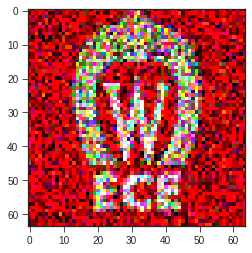

1 / 18


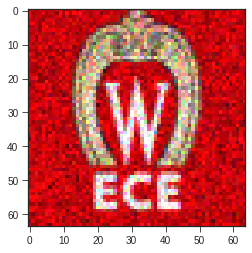

2 / 18


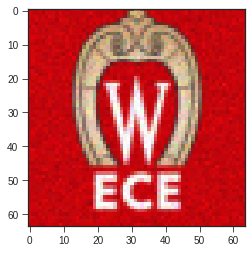

3 / 18


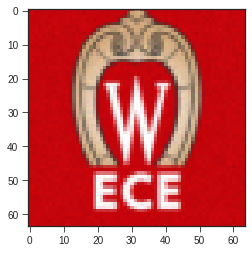

4 / 18


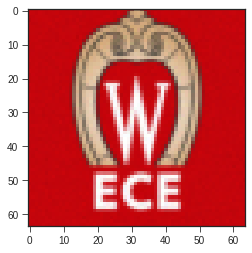

5 / 18


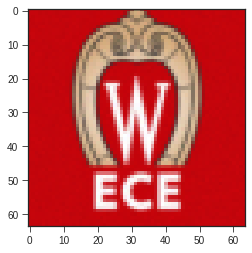

6 / 18


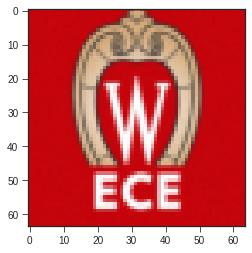

7 / 18


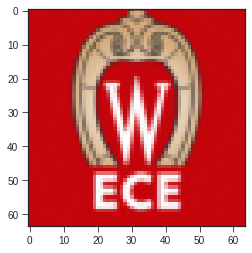

8 / 18


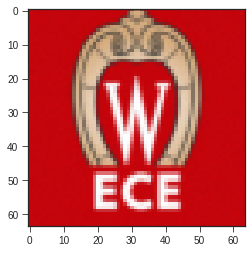

9 / 18


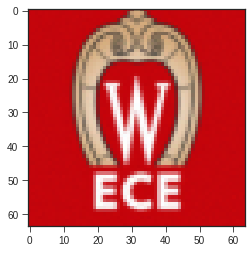

10 / 18


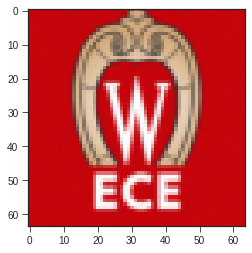

11 / 18


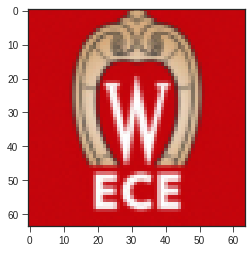

12 / 18


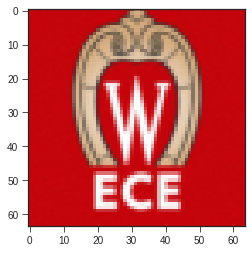

13 / 18


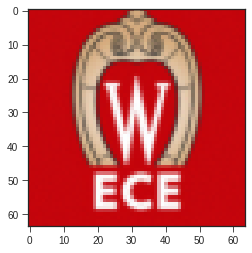

14 / 18


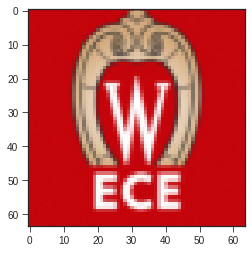

15 / 18


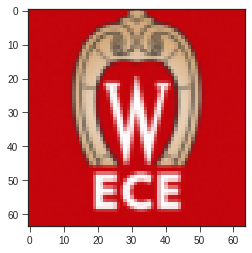

16 / 18


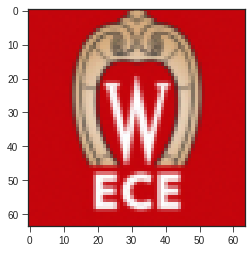

17 / 18


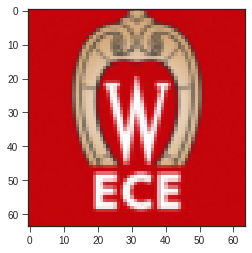

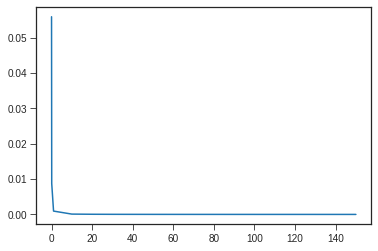

In [10]:
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    recons = np.zeros((r,c,layers));
    for layer in range(layers):
        recons[:,:,layer] = np.reshape(measure_voxtel[:,layer, time_index],(r,c));
    recons_clipped = np.clip(recons, a_min = 0, a_max = 1);
    plt.figure();
    plt.imshow(recons_clipped);
    plt.show();
    this_error = (np.mean((recons_clipped - pmt.img)**2));

    Error_voxtel[time_index] = this_error;
plt.figure();
plt.plot(time, Error_voxtel);
plt.show();

0 / 18


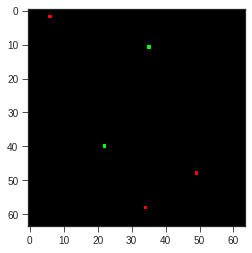

1 / 18


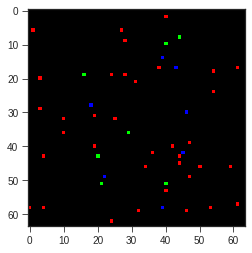

2 / 18


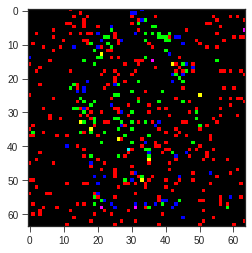

3 / 18


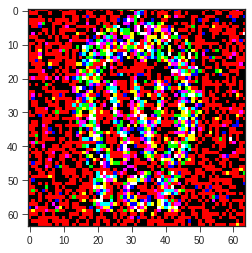

4 / 18


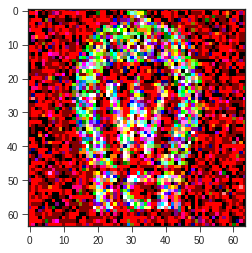

5 / 18


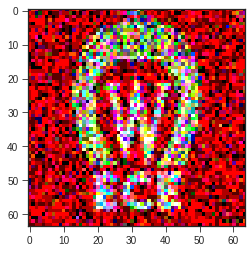

6 / 18


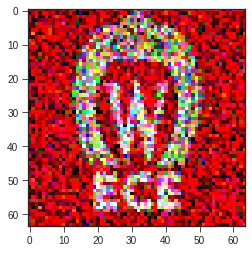

7 / 18


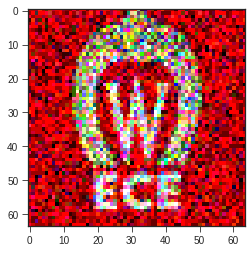

8 / 18


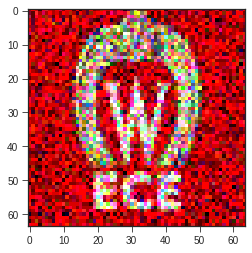

9 / 18


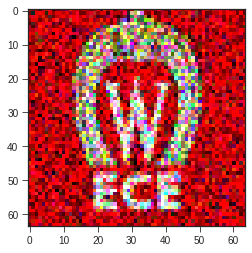

10 / 18


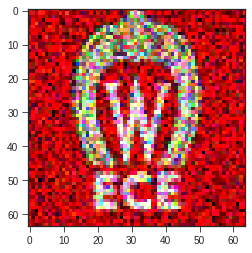

11 / 18


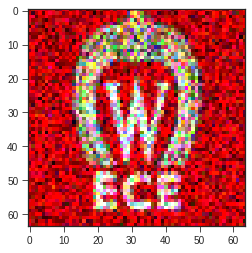

12 / 18


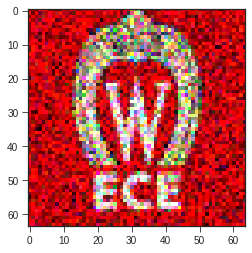

13 / 18


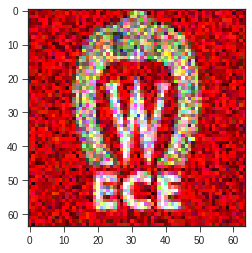

14 / 18


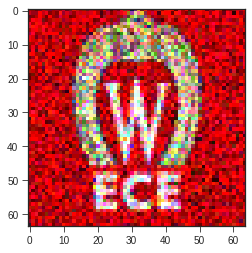

15 / 18


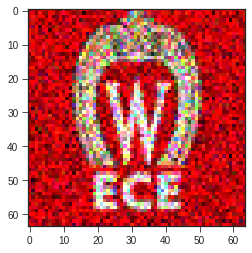

16 / 18


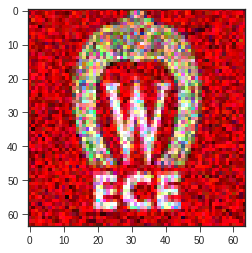

17 / 18


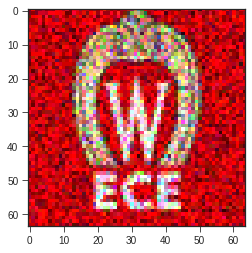

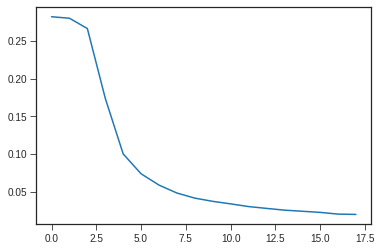

In [11]:
## raster local recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, raster_inv, measure_raster_local[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_raster_local[time_index] = this_error;
plt.figure();
plt.plot(Error_raster_local);


0 / 18


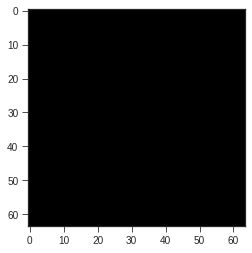

1 / 18


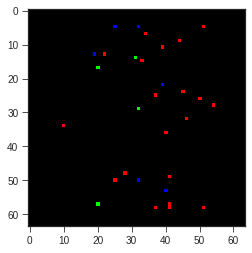

2 / 18


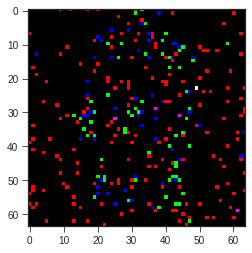

3 / 18


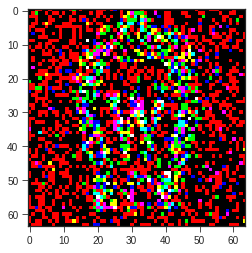

4 / 18


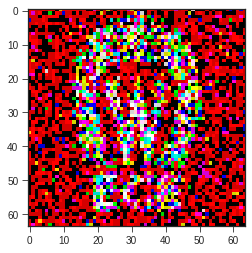

5 / 18


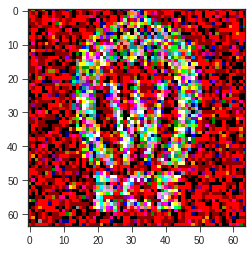

6 / 18


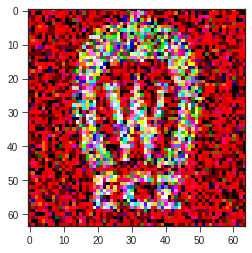

7 / 18


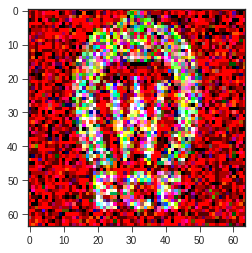

8 / 18


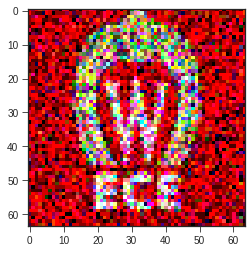

9 / 18


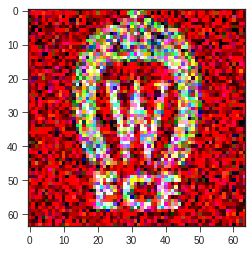

10 / 18


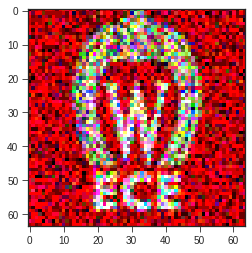

11 / 18


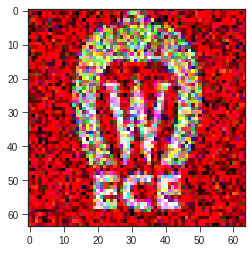

12 / 18


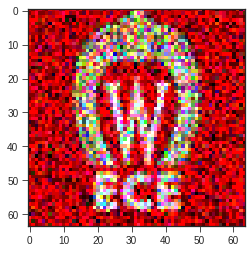

13 / 18


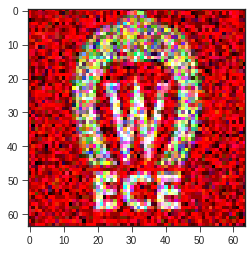

14 / 18


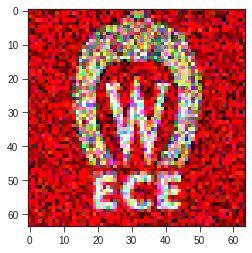

15 / 18


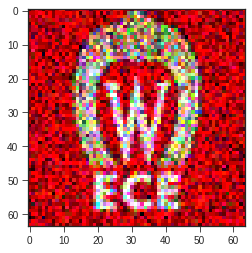

16 / 18


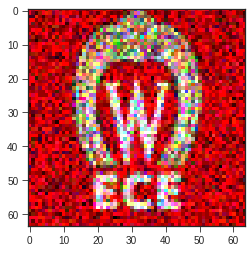

17 / 18


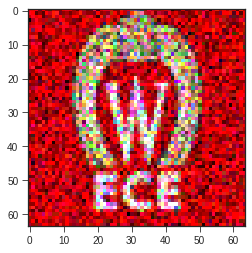

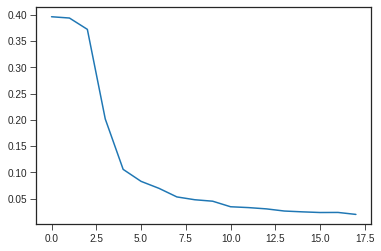

In [12]:
## raster global recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, raster_inv, measure_raster_global[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img))**2)**0.5;
    
    Error_raster_global[time_index] = this_error;
    
plt.figure();
plt.plot(Error_raster_global);

0 / 18


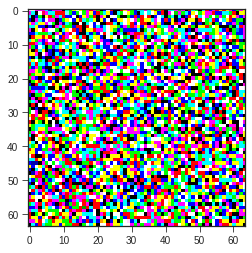

1 / 18


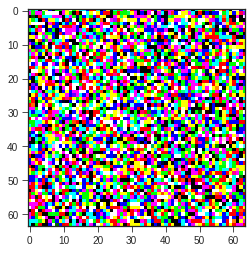

2 / 18


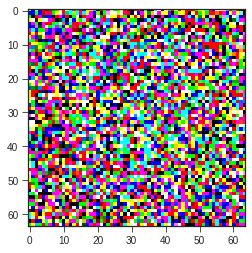

3 / 18


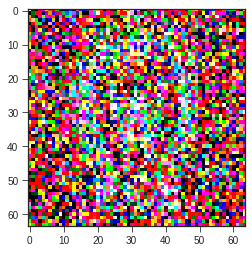

4 / 18


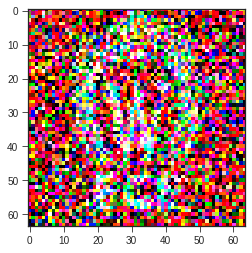

5 / 18


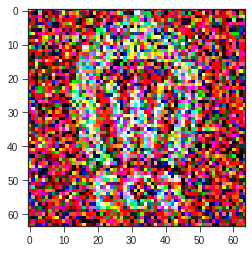

6 / 18


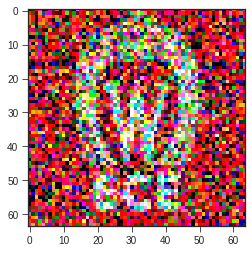

7 / 18


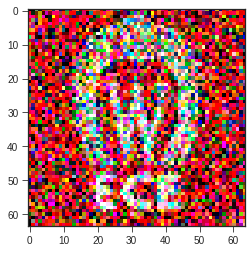

8 / 18


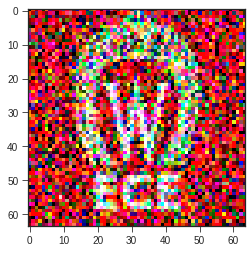

9 / 18


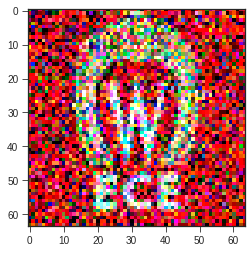

10 / 18


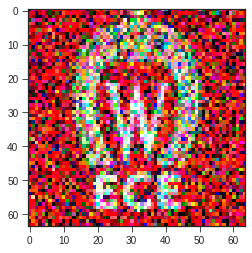

11 / 18


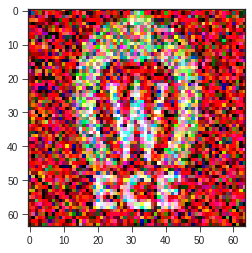

12 / 18


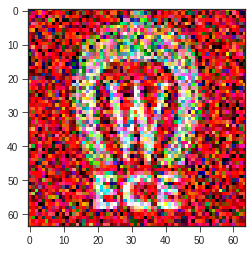

13 / 18


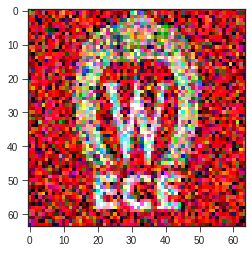

14 / 18


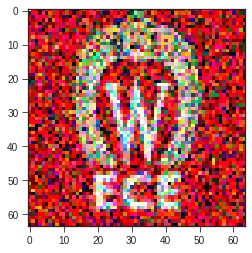

15 / 18


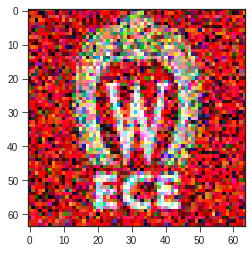

16 / 18


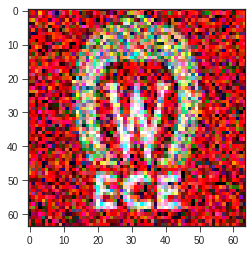

17 / 18


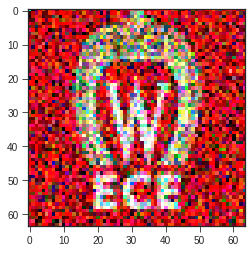

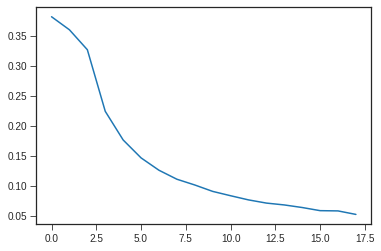

In [13]:
## basis recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, basis_inv, measure_basis[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_basis[time_index] = this_error;

plt.figure();
plt.plot(Error_basis);


0 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 3.357e+06} |··················································| 0.0%
{cost = 1.402e+01} |>>>>>>>>>>········································| 20.0%
{cost = 4.043e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.027e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.437e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.712e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

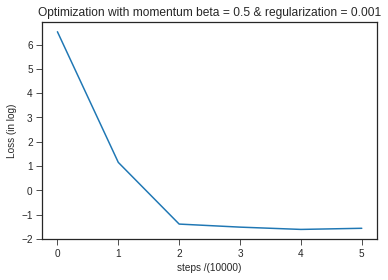

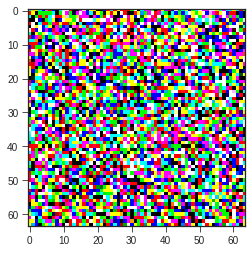

1 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.914e+06} |··················································| 0.0%
{cost = 2.231e+00} |>>>>>>>>>>········································| 20.0%
{cost = 3.621e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.604e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.664e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.588e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

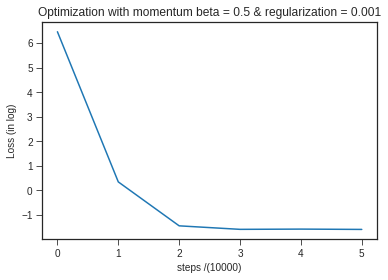

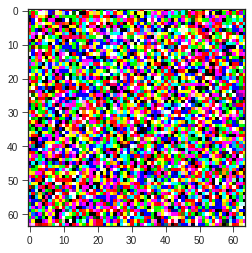

2 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.844e+06} |··················································| 0.0%
{cost = 2.349e-01} |>>>>>>>>>>········································| 20.0%
{cost = 2.635e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.191e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.615e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.991e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

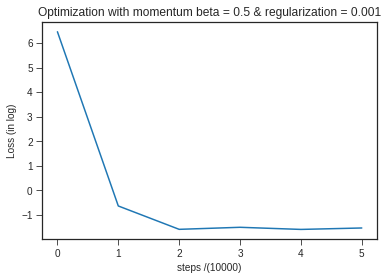

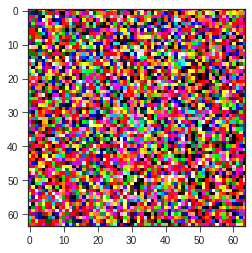

3 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.842e+06} |··················································| 0.0%
{cost = 7.375e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.593e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.357e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.459e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.472e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

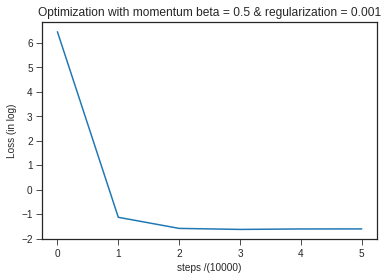

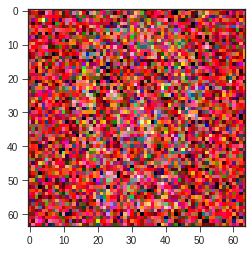

4 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 5.255e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.949e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.261e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.315e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.526e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

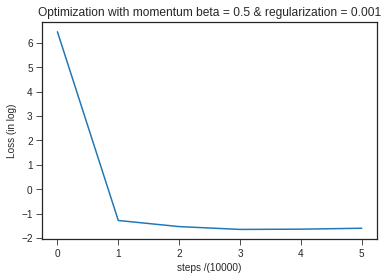

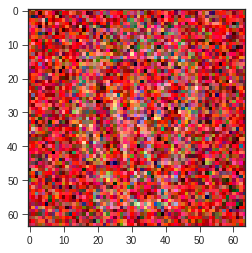

5 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.842e+06} |··················································| 0.0%
{cost = 5.126e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.986e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.555e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.225e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.663e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

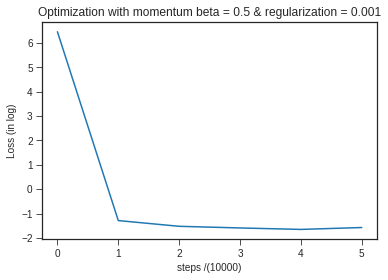

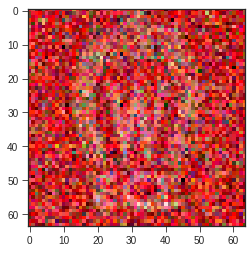

6 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.844e+06} |··················································| 0.0%
{cost = 4.905e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.458e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.310e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.064e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.117e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

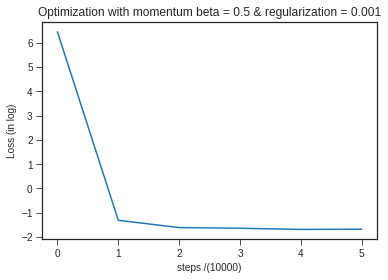

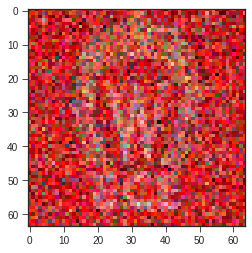

7 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.842e+06} |··················································| 0.0%
{cost = 4.253e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.782e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.244e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.066e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.172e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

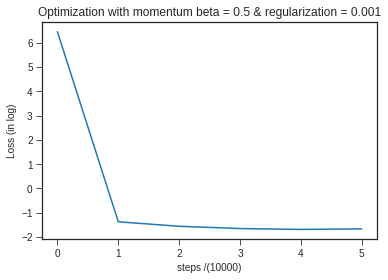

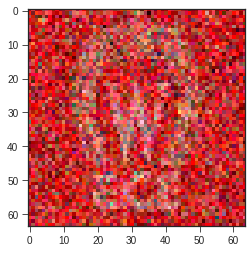

8 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.842e+06} |··················································| 0.0%
{cost = 3.781e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.563e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.192e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.152e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.555e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

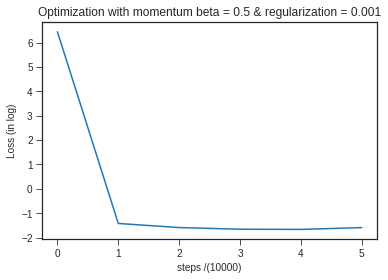

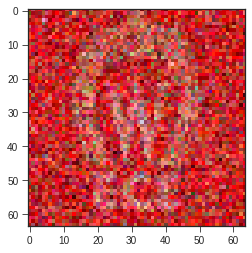

9 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.842e+06} |··················································| 0.0%
{cost = 5.029e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.285e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.112e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.140e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.326e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

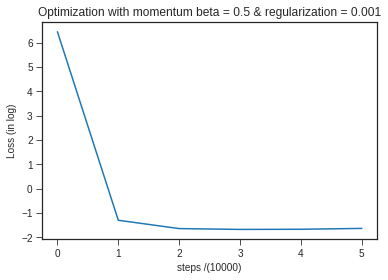

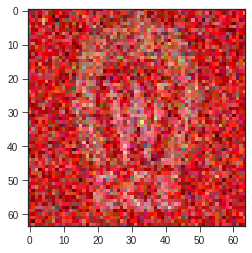

10 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 3.682e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.221e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.249e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.690e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.134e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

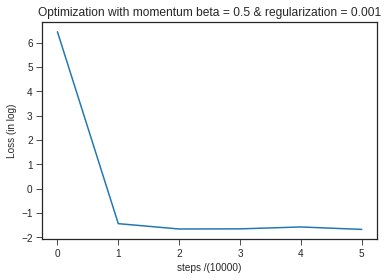

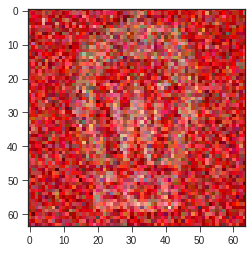

11 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 5.757e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.307e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.142e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.339e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.106e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

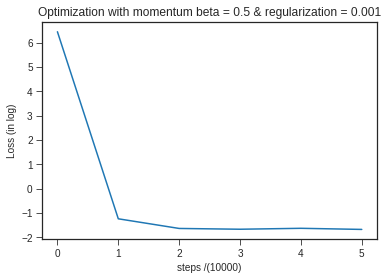

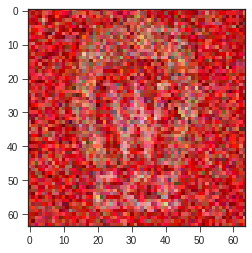

12 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 3.517e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.277e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.989e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.002e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.083e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

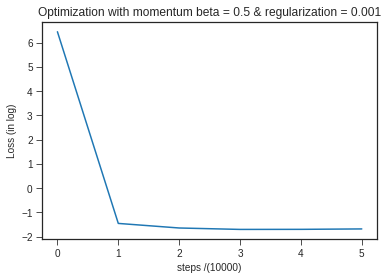

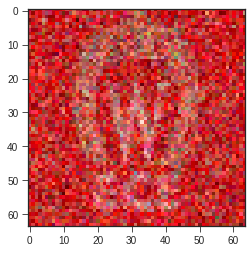

13 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 3.574e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.952e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.051e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.181e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.891e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

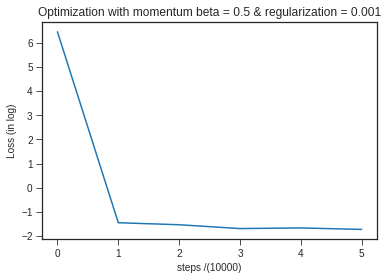

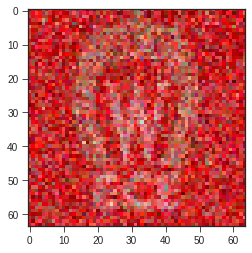

14 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 4.232e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.541e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.286e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.045e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.382e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

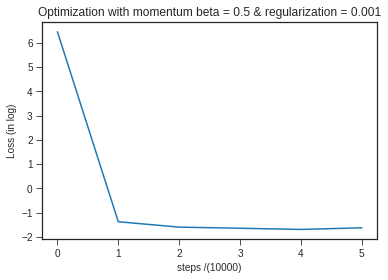

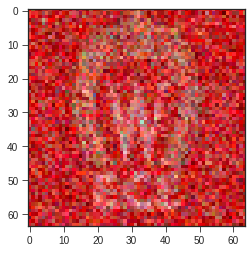

15 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 3.275e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.865e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.102e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.904e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.225e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

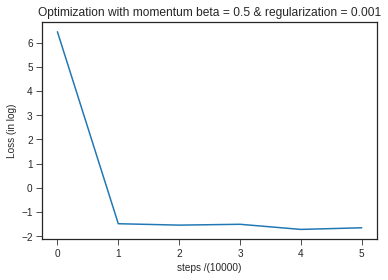

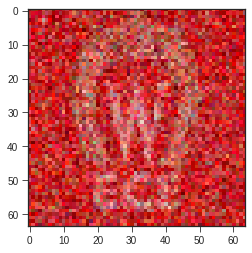

16 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.842e+06} |··················································| 0.0%
{cost = 3.714e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.075e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.091e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.616e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.144e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

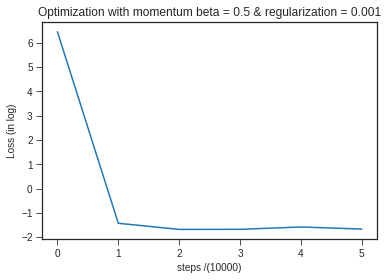

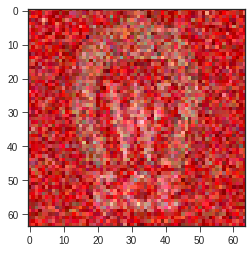

17 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.843e+06} |··················································| 0.0%
{cost = 3.559e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.390e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.038e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.111e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.012e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

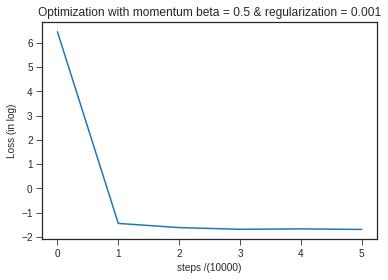

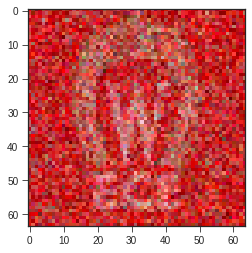

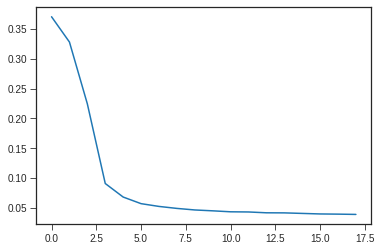

In [14]:
## cs recons

for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_cs[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 1e-3, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_cs[time_index] = this_error;
plt.figure();
plt.plot(Error_cs);    

0 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 3.440e+06} |··················································| 0.0%
{cost = 1.043e+03} |>>>>>>>>>>········································| 20.0%
{cost = 1.046e+03} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.996e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.079e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 8.452e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

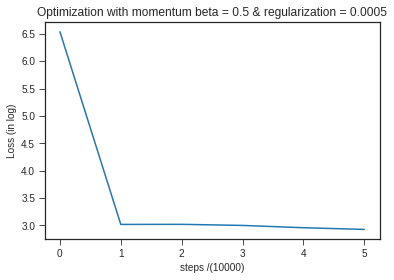

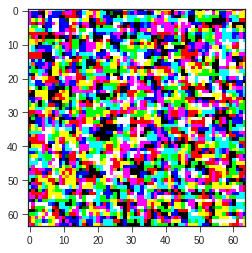

1 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.930e+06} |··················································| 0.0%
{cost = 1.119e+02} |>>>>>>>>>>········································| 20.0%
{cost = 1.179e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.250e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.536e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 8.354e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

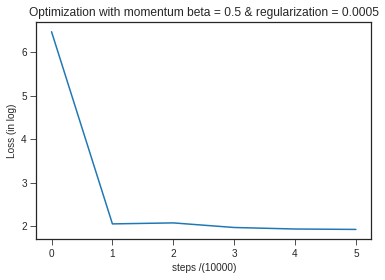

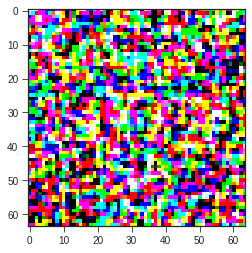

2 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.854e+06} |··················································| 0.0%
{cost = 1.366e+01} |>>>>>>>>>>········································| 20.0%
{cost = 1.299e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.247e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.204e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.023e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

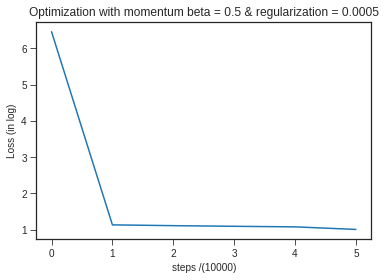

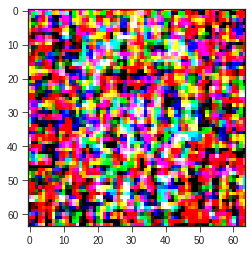

3 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.850e+06} |··················································| 0.0%
{cost = 6.784e-01} |>>>>>>>>>>········································| 20.0%
{cost = 5.892e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.605e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 5.391e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 4.754e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

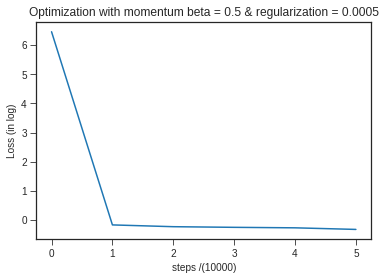

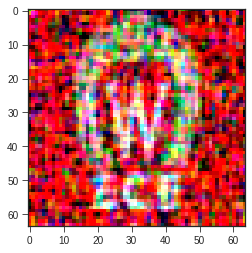

4 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.847e+06} |··················································| 0.0%
{cost = 9.099e-01} |>>>>>>>>>>········································| 20.0%
{cost = 8.216e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 7.766e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.029e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 7.553e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

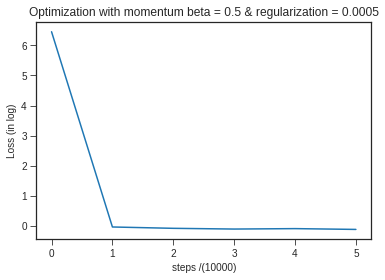

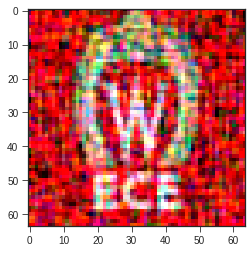

5 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.848e+06} |··················································| 0.0%
{cost = 1.584e+00} |>>>>>>>>>>········································| 20.0%
{cost = 1.610e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.451e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.275e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.200e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

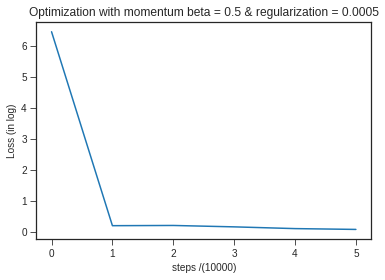

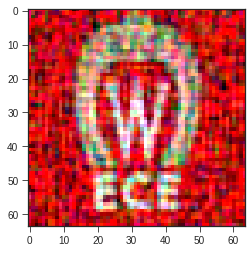

6 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 7.209e-01} |>>>>>>>>>>········································| 20.0%
{cost = 6.481e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.758e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 6.055e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.706e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

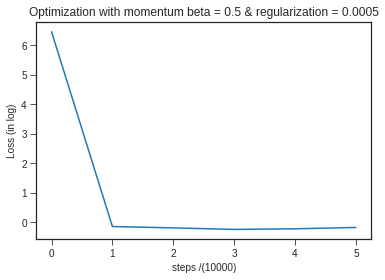

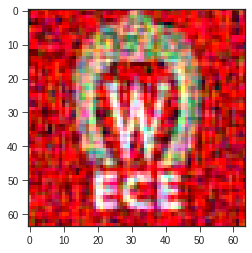

7 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.848e+06} |··················································| 0.0%
{cost = 1.195e-01} |>>>>>>>>>>········································| 20.0%
{cost = 7.411e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 7.922e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 7.037e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.847e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

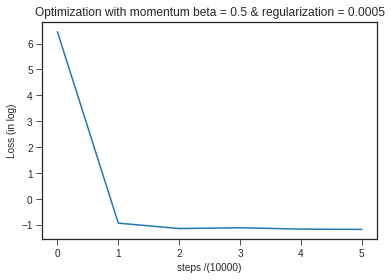

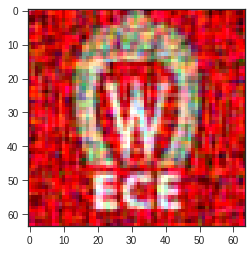

8 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 7.269e-02} |>>>>>>>>>>········································| 20.0%
{cost = 4.207e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.878e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.814e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.516e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

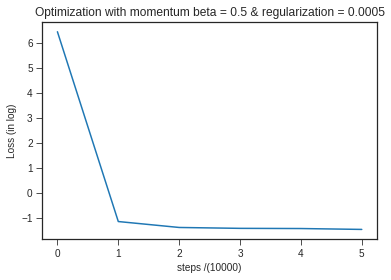

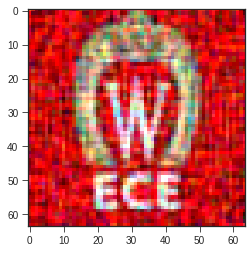

9 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 1.806e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.497e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.473e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.399e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.275e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

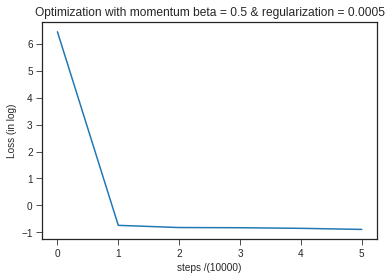

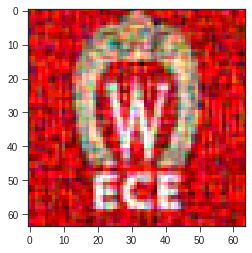

10 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.850e+06} |··················································| 0.0%
{cost = 1.354e-01} |>>>>>>>>>>········································| 20.0%
{cost = 7.190e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 7.426e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 6.772e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.581e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

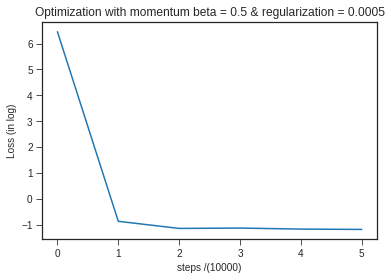

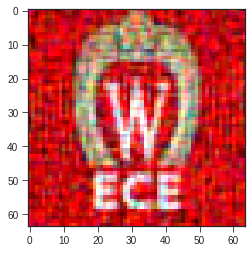

11 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 9.232e-02} |>>>>>>>>>>········································| 20.0%
{cost = 6.300e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 6.935e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 5.716e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 5.248e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

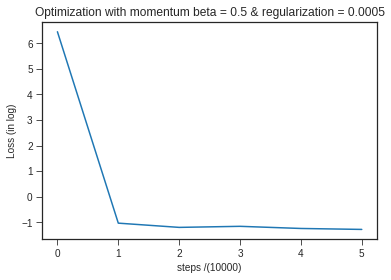

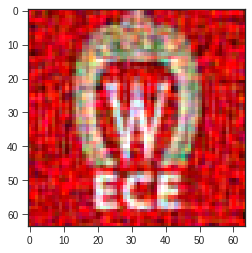

12 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 7.436e-02} |>>>>>>>>>>········································| 20.0%
{cost = 4.670e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.698e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.570e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 4.063e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

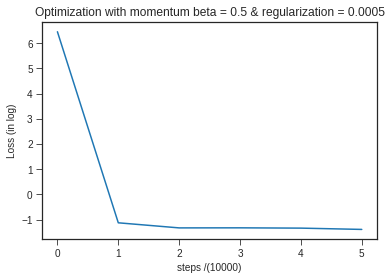

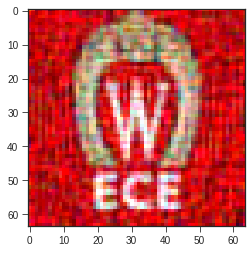

13 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 1.276e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.115e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.108e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.755e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.463e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

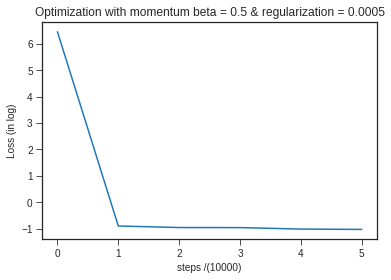

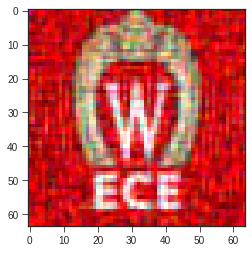

14 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 6.602e-02} |>>>>>>>>>>········································| 20.0%
{cost = 3.279e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.241e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.939e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.815e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

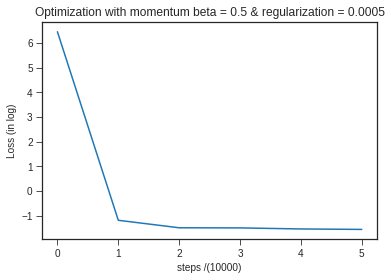

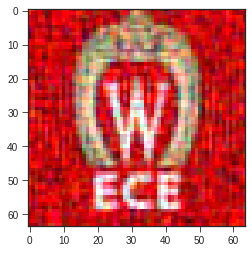

15 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.850e+06} |··················································| 0.0%
{cost = 7.002e-01} |>>>>>>>>>>········································| 20.0%
{cost = 5.962e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.655e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 5.405e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 5.273e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

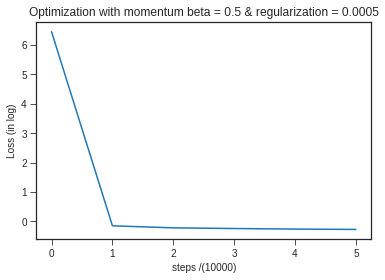

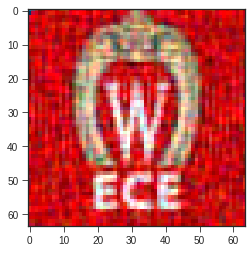

16 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.850e+06} |··················································| 0.0%
{cost = 1.683e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.316e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.283e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.150e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 8.074e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

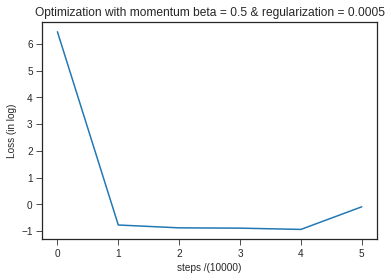

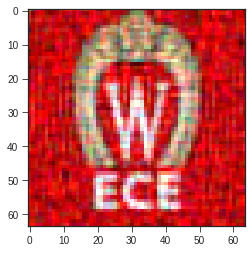

17 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 1.412e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.068e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.040e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.794e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.277e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

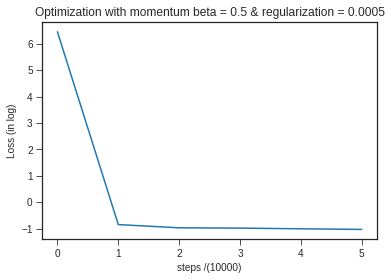

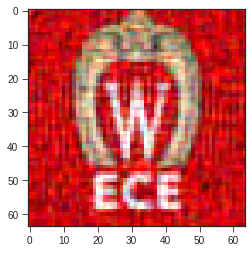

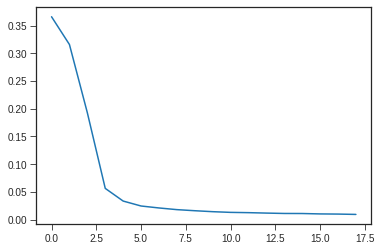

In [15]:
## hr recons
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_hr[:,:,time_index], upload_DMD_basis = mask_hr,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_hr[time_index] = this_error;
plt.figure();
plt.plot(Error_hr); 

In [16]:
## hr + Haar recons
"""
Haar_phi = Haar_2d(r).T; ## using inverse matrix

for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_hr[:,:,time_index], upload_DMD_basis = mask_hr,
                        upload_phi = Haar_phi,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_hr_Haar[time_index] = this_error;
plt.figure();
plt.plot(Error_hr); 
"""

"\nHaar_phi = Haar_2d(r).T; ## using inverse matrix\n\nfor time_index in range(len(time)):\n    print(time_index, '/', len(time));\n    pmt.PMT_reconstruct(r,c,measure_hr[:,:,time_index], upload_DMD_basis = mask_hr,\n                        upload_phi = Haar_phi,\n                        user_evaluation = False, learning_rate = 2e-3,\n                        regularization = 5e-4, plot_step= 10000, max_epoch = 50000);\n    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,\n                        user_evaluation = False, learning_rate = 2e-3,\n                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''\n    #plt.figure();\n    #plt.plot(pmt.W[:,0]);\n    #plt.show();\n    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);\n    this_error = (np.mean((recons_clipped - pmt.img)**2));\n    \n    Error_hr_Haar[time_index] = this_error;\nplt.figure();\nplt.plot(Error_hr); \n"

0 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 3.424e+03} |··················································| 0.0%
{cost = 2.325e+02} |>>>>>>>>>>········································| 20.0%
{cost = 8.844e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 8.780e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.318e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.200e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

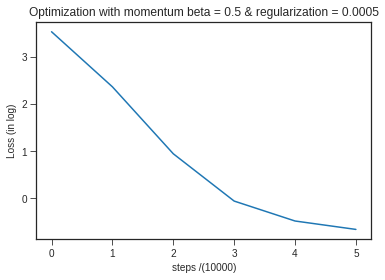

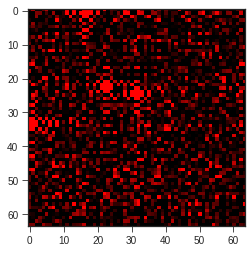

1 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 4.622e+02} |··················································| 0.0%
{cost = 3.064e+01} |>>>>>>>>>>········································| 20.0%
{cost = 4.767e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.883e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.212e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.615e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

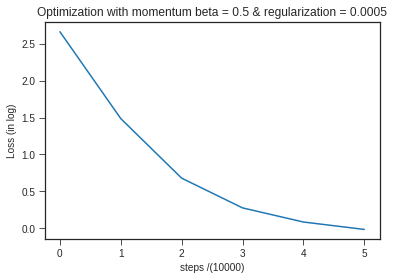

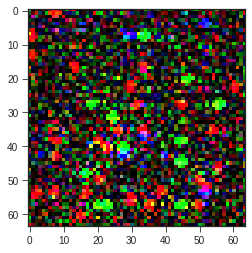

2 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 4.862e+01} |··················································| 0.0%
{cost = 4.998e+00} |>>>>>>>>>>········································| 20.0%
{cost = 1.638e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.041e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.498e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 7.731e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

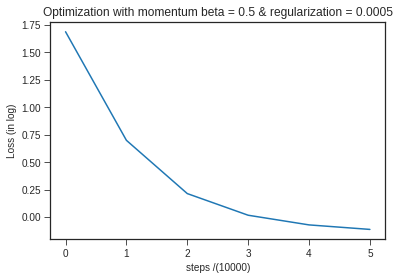

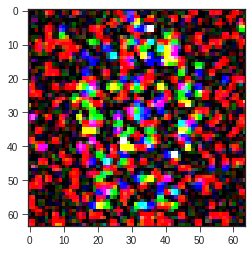

3 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.411e+01} |··················································| 0.0%
{cost = 1.544e+00} |>>>>>>>>>>········································| 20.0%
{cost = 6.474e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.119e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.802e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 4.595e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

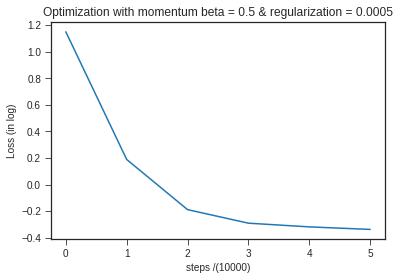

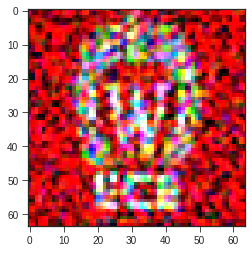

4 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.202e+01} |··················································| 0.0%
{cost = 1.235e+00} |>>>>>>>>>>········································| 20.0%
{cost = 5.270e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.250e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.951e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.878e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

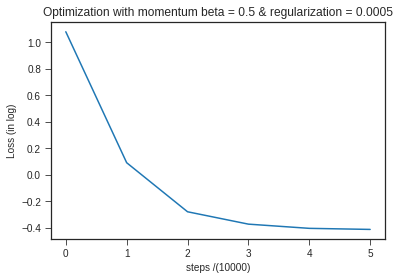

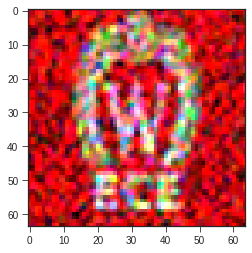

5 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.143e+01} |··················································| 0.0%
{cost = 1.075e+00} |>>>>>>>>>>········································| 20.0%
{cost = 4.496e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.741e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.506e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.460e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

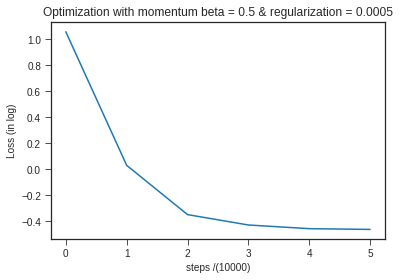

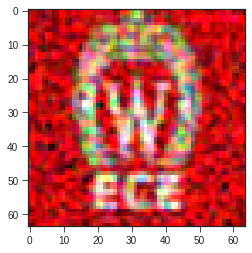

6 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.099e+01} |··················································| 0.0%
{cost = 1.018e+00} |>>>>>>>>>>········································| 20.0%
{cost = 4.147e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.397e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.270e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.189e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

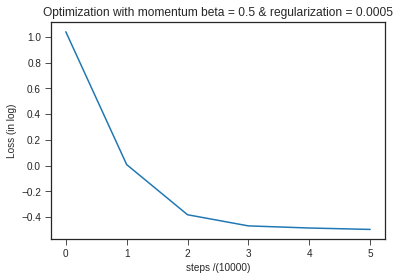

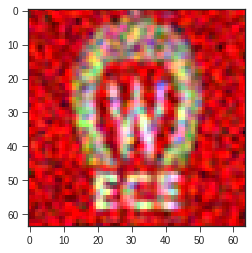

7 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.064e+01} |··················································| 0.0%
{cost = 9.729e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.918e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.262e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.129e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.070e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

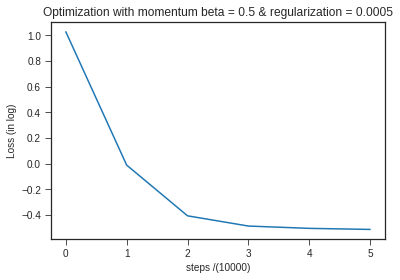

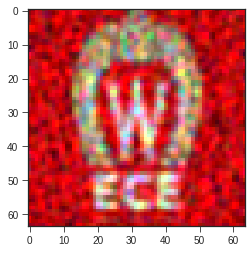

8 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.076e+01} |··················································| 0.0%
{cost = 9.661e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.829e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.182e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.031e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.000e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

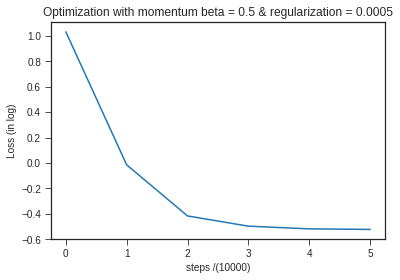

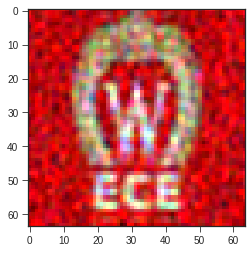

9 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.071e+01} |··················································| 0.0%
{cost = 9.282e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.584e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.939e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.856e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.810e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

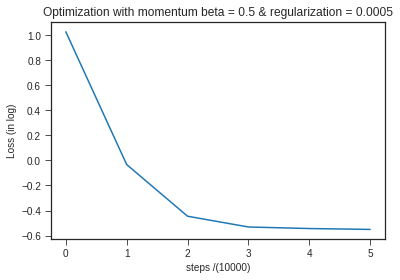

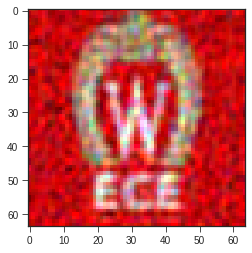

10 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.063e+01} |··················································| 0.0%
{cost = 9.326e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.598e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.957e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.796e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.760e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

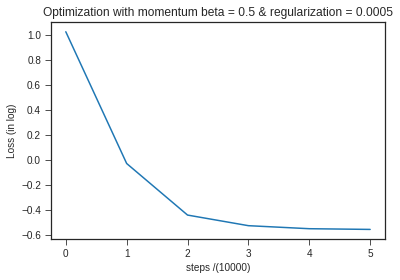

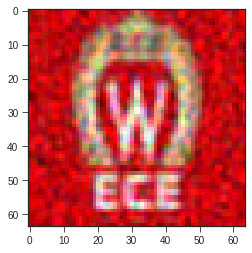

11 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.065e+01} |··················································| 0.0%
{cost = 9.001e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.348e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.768e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.632e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.599e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

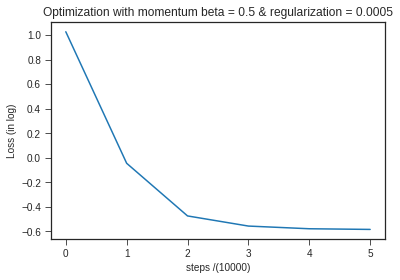

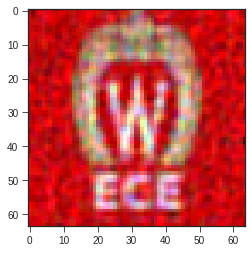

12 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.055e+01} |··················································| 0.0%
{cost = 8.738e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.297e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.718e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.581e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.538e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

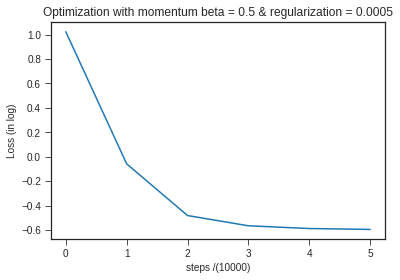

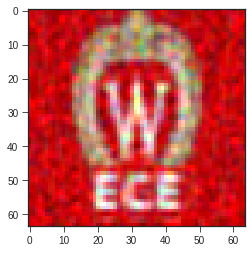

13 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.058e+01} |··················································| 0.0%
{cost = 8.753e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.174e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.624e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.519e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.484e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

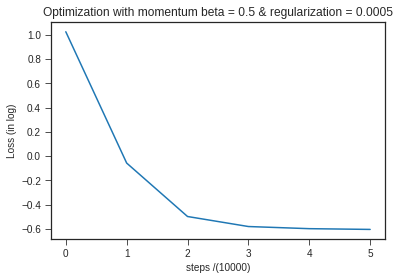

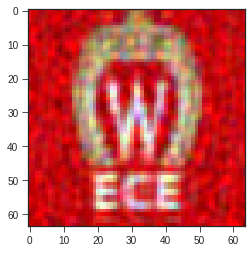

14 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.045e+01} |··················································| 0.0%
{cost = 8.603e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.177e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.585e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.491e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.448e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

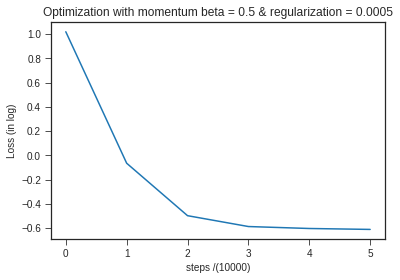

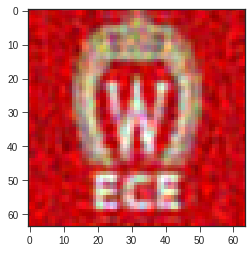

15 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.037e+01} |··················································| 0.0%
{cost = 8.417e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.056e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.516e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.407e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.403e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

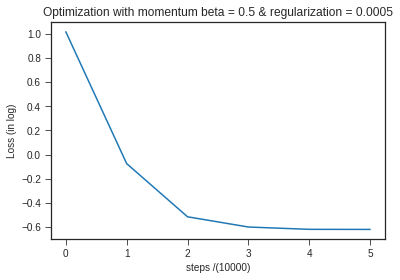

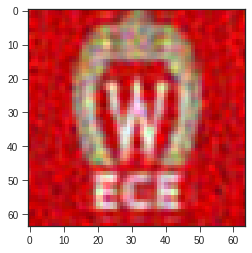

16 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.043e+01} |··················································| 0.0%
{cost = 8.498e-01} |>>>>>>>>>>········································| 20.0%
{cost = 2.985e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.448e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.324e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.308e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

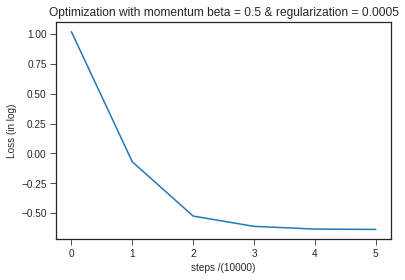

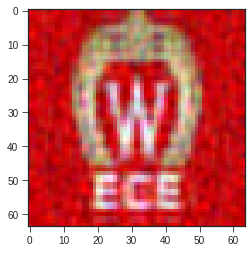

17 / 18
Mini-batch (size 10) Gradient Ascent!

{cost = 1.057e+01} |··················································| 0.0%
{cost = 8.406e-01} |>>>>>>>>>>········································| 20.0%
{cost = 2.997e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.445e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.352e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.316e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

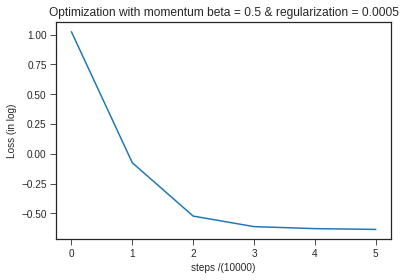

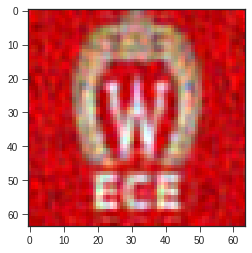

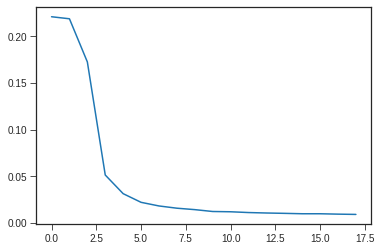

In [17]:
## hyper raster recons
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_hr2[:,:,time_index], upload_DMD_basis = mask_hr2,
                        user_evaluation = False, learning_rate = 5e-2,
                        regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_hr2[time_index] = this_error;
plt.figure();
plt.plot(Error_hr2);

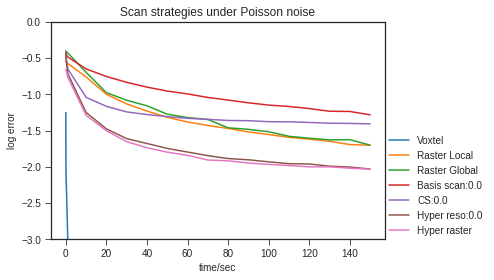

In [18]:
plt.figure();
plt.plot(time, np.log10(Error_voxtel), label = "Voxtel")
plt.plot(time, np.log10(Error_raster_local), label = "Raster Local");
plt.plot(time, np.log10(Error_raster_global), label = "Raster Global");
plt.plot(time, np.log10(Error_basis), label = "Basis scan:"+str(ratio_val));
plt.plot(time, np.log10(Error_cs), label = "CS:" +str(ratio_val));
plt.plot(time, np.log10(Error_hr), label = "Hyper reso:"+str(ratio_val));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");
plt.plot(time, np.log10(Error_hr2), label = "Hyper raster");
plt.xlabel("time/sec");
plt.ylabel("log error");
plt.ylim(-3,-0.)
plt.title("Scan strategies under Poisson noise")
plt.legend(loc=[1,0]);
plt.show();

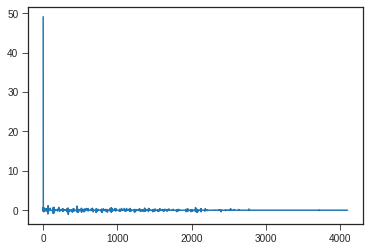

In [19]:
plt.figure();
plt.plot(pmt.W[:,0])

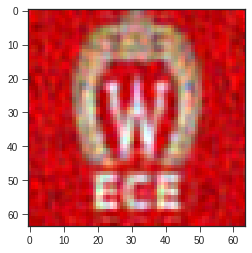

In [20]:
img_vector2 = pmt.FT_Basis.dot(pmt.W * (np.abs(pmt.W) > np.max(np.abs(pmt.W)) * 1e-14));
img2 = np.zeros((r,c,3));
for i in range(3):
    img2[:,:,i] = np.reshape(img_vector2[:,i], (r,c));
    
recons_clipped = np.clip(img2, a_min = 0, a_max = 1);
plt.figure();
plt.imshow(recons_clipped);

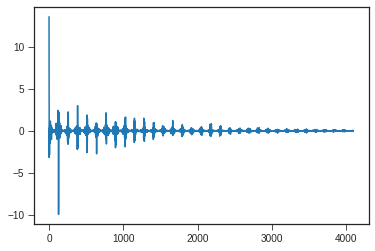

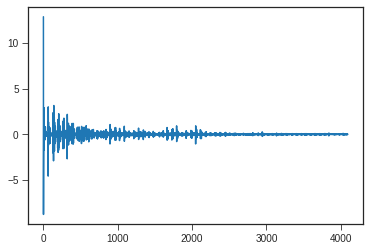

In [21]:
img_vector =np.reshape(pmt.img[:,:,1], (-1,1));
dct_domain = pmt.DCT_Matrix(64*64);
dct2_domain = pmt.DCT_Basis(64,64);
real_W = dct_domain.dot(img_vector);
plt.figure();
plt.plot(real_W);
plt.figure();
plt.plot(dct2_domain.dot(img_vector))

In [22]:
print("Raster local: The photons per mask per pixel is %.3e"%(light_level_raster_local));
print("Raster global: The photons per mask per pixel is %.3e"%(light_level_raster_global));
print("Basis scan: The photons per mask per pixel is %.3e"%(light_level_basis));
print("CS: The photons per mask per pixel for is %.3e"%(light_level_cs));
print("Hyper reso: The photons per mask per pixel for is %.3e"%(light_level_hr));
print("Hyper raster: The photons per mask per pixel for  is %.3e"%(light_level_hr2));

Raster local: The photons per mask per pixel is 1.465e+01
Raster global: The photons per mask per pixel is 8.941e+00
Basis scan: The photons per mask per pixel is 1.788e+01
CS: The photons per mask per pixel for is 5.965e+01
Hyper reso: The photons per mask per pixel for is 5.959e+01
Hyper raster: The photons per mask per pixel for  is 1.465e+01
